# Puzzle Solver 🧩

In [8]:
# Don't worry about it it just used for easier coding:
import os
import glob

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [9]:
# path of dataset change with your own path
folder_path = r"Puzzle_2_160"

In [10]:
#Read Images
output_file = os.path.join(folder_path, "Output.tif")
patch_files = glob.glob(os.path.join(folder_path, "Patch_*.tif"))

corners_img = np.array(Image.open(output_file))
# Get copy of image to edit it later
base_img = corners_img.copy()

patches = [np.array(Image.open(patch_file)) for patch_file in patch_files]

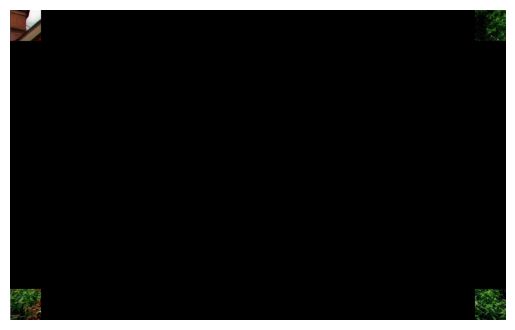

In [11]:
plt.imshow(base_img)
plt.axis('off')
plt.show()

In [12]:
# TODO:
# Now you should solve puzzle do it the best you can.
import numpy as np
import matplotlib.pyplot as plt

def puzzle_solver(strip_width: int = 3, animate: bool = True, pause: float = 0.08):
    """
    Greedy border-matching solver with single-cell inline animation.
    - Uses mean edge cost across available neighbors (fair when 1/2/3 borders touch).
    - Frontiers and neighbors are read from the canvas (final_img) itself.
    - Updates the SAME figure each step (no extra figures).
    """
    from IPython.display import clear_output, display  # keep deps local to the function

    # --- Geometry inferred from loaded data ---
    H, W = base_img.shape[:2]
    ph, pw = patches[0].shape[0], patches[0].shape[1]
    rows, cols = H // ph, W // pw

    final_img = base_img.copy()
    used = set()  # indices of patches that are already placed

    # Try to mark corner pieces as used (if they exist among Patch_*.tif)
    def try_mark_corners_as_used():
        corner_coords = [(0, 0), (0, cols-1), (rows-1, 0), (rows-1, cols-1)]
        for (r, c) in corner_coords:
            y0, y1 = r*ph, (r+1)*ph
            x0, x1 = c*pw, (c+1)*pw
            region = final_img[y0:y1, x0:x1, :]
            if float(np.mean(region)) < 1.0:
                continue
            for idx, tile in enumerate(patches):
                if idx in used:
                    continue
                if tile.shape == region.shape and np.array_equal(tile, region):
                    used.add(idx)
                    break
    try_mark_corners_as_used()

    s = strip_width

    def is_empty(r, c):
        """Empty if the cell is nearly black (dataset uses black gaps)."""
        y0, y1 = r*ph, (r+1)*ph
        x0, x1 = c*pw, (c+1)*pw
        return float(np.mean(final_img[y0:y1, x0:x1, :])) < 1.0

    def neighbor_edges_from_canvas(r, c):
        """Extract neighbor edge strips directly from the canvas."""
        y0, y1 = r*ph, (r+1)*ph
        x0, x1 = c*pw, (c+1)*pw
        reg = final_img[y0:y1, x0:x1, :].astype(np.float32)
        return {"top": reg[:s], "bottom": reg[-s:], "left": reg[:, :s], "right": reg[:, -s:]}

    def extract_edges(tile):
        h, w = tile.shape[:2]
        ss = min(s, h//2, w//2)
        return {"top": tile[:ss].astype(np.float32), "bottom": tile[-ss:].astype(np.float32),
                "left": tile[:, :ss].astype(np.float32), "right": tile[:, -ss:].astype(np.float32)}

    pre_edges = {i: extract_edges(t) for i, t in enumerate(patches)}

    def edge_cost(a, b):
        """L1 mean absolute difference (robust for edge strips)."""
        return float(np.mean(np.abs(a.astype(np.float32) - b.astype(np.float32))))

    def pair_cost(idx, r, c):
        """Mean cost over existing borders so cells with 1/2/3 borders are comparable."""
        cand = pre_edges[idx]
        total, cnt = 0.0, 0
        if r-1 >= 0 and not is_empty(r-1, c):
            up = neighbor_edges_from_canvas(r-1, c);     total += edge_cost(up["bottom"], cand["top"]);    cnt += 1
        if r+1 < rows and not is_empty(r+1, c):
            dn = neighbor_edges_from_canvas(r+1, c);     total += edge_cost(dn["top"],    cand["bottom"]); cnt += 1
        if c-1 >= 0 and not is_empty(r, c-1):
            lf = neighbor_edges_from_canvas(r, c-1);     total += edge_cost(lf["right"],  cand["left"]);   cnt += 1
        if c+1 < cols and not is_empty(r, c+1):
            rg = neighbor_edges_from_canvas(r, c+1);     total += edge_cost(rg["left"],   cand["right"]);  cnt += 1
        return 1e12 if cnt == 0 else (total / cnt)

    # --- Single output / single figure animation ---
    fig, ax = None, None
    if animate:
        fig, ax = plt.subplots(figsize=(8, 5))
        im = ax.imshow(final_img)
        ax.axis('off')
        ax.set_title("Assembling...")
        clear_output(wait=True); display(fig)

    total_tiles = rows * cols
    fixed_corners = 4
    total_to_place = total_tiles - fixed_corners  # 36 for 5x8
    steps = 0

    while True:
        # Build frontier = empty cells touching at least one filled neighbor
        frontier = []
        for r in range(rows):
            for c in range(cols):
                if not is_empty(r, c):
                    continue
                if ((r-1 >= 0 and not is_empty(r-1, c)) or
                    (r+1 < rows and not is_empty(r+1, c)) or
                    (c-1 >= 0 and not is_empty(r, c-1)) or
                    (c+1 < cols and not is_empty(r, c+1))):
                    frontier.append((r, c))

        if not frontier:
            break

        remaining = [i for i in range(len(patches)) if i not in used]
        if not remaining:
            break

        best_cost, best_pos, best_idx = float("inf"), None, None
        for r, c in frontier:
            for idx in remaining:
                cst = pair_cost(idx, r, c)
                if cst < best_cost:
                    best_cost, best_pos, best_idx = cst, (r, c), idx

        if best_pos is None:
            break

        # Commit placement
        r, c = best_pos
        y0, y1 = r*ph, (r+1)*ph; x0, x1 = c*pw, (c+1)*pw
        final_img[y0:y1, x0:x1, :] = patches[best_idx]
        used.add(best_idx)
        steps += 1

        if animate:
            im.set_data(final_img)
            # If you want to count from 4 (including fixed corners), use 4+steps:
            ax.set_title(f"Assembling... placed {4+steps} / {total_tiles}")
            clear_output(wait=True); display(fig)

        if steps >= total_to_place:
            break

    if animate:
        ax.set_title("Done")
        clear_output(wait=True); display(fig)

    return final_img


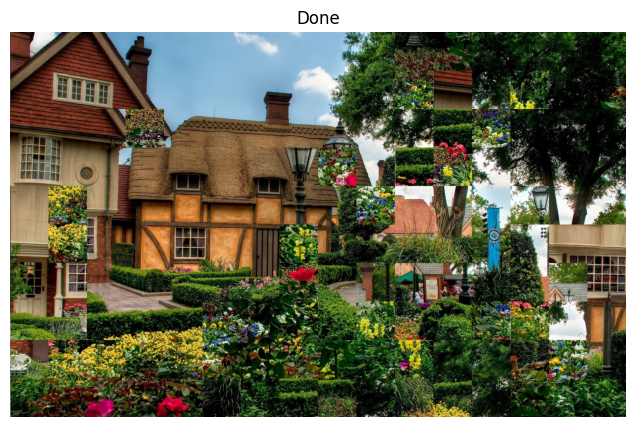

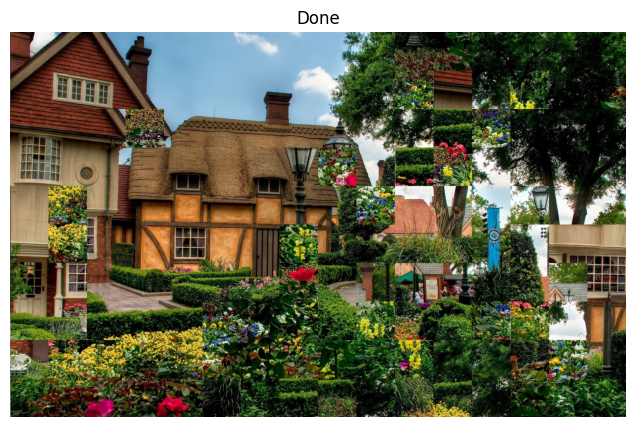

In [13]:
# Test and Save final Image
final_img = puzzle_solver()
Image.fromarray(final_img).save(os.path.join(folder_path, "final.tif"))

In [14]:
# Now it's time to find what's our final image good base on original image

# This properties are determined according to the dataset:
rows, cols = 5, 8
img_width, img_height = 1920, 1200
patch_width, patch_height = img_width // cols, img_height // rows

def accuracy_block_base(original_img, final_img, rows, cols):
    correct_blocks = 0
    total_blocks = rows * cols
    for row in range(rows):
        for col in range(cols):
            patch = final_img[row*patch_height:(row+1)*patch_height, col*patch_width:(col+1)*patch_width]
            original_patch = original_img[row*patch_height:(row+1)*patch_height, col*patch_width:(col+1)*patch_width]

            if np.array_equal(patch, original_patch):
                correct_blocks += 1

    return 100 * correct_blocks / total_blocks

original_img = np.array(Image.open(os.path.join(folder_path, "Original.tif")))
accuracy= accuracy_block_base(original_img, final_img, rows, cols)
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 12.50%


In [ ]:
# show final_img - You can make animation for it while solving puzzle. That's fun!
plt.imshow(final_img)
plt.axis('off')
plt.show()